# KNN exercise

##### (Notebook By Itay Hazan)

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.model_selection import train_test_split

## Step 1: Visualizing KNN

Complete the following code that samples $n=30$ uniformly-distributed random points in $ [0,1] \times [0,1] $ and samples a label between 0 and `max_label`=3, that is sample $X \in \left([0,1]\times [0,1]\right)^{n \times 2} $ and $ y \in \{0,\dots, \text{max_label} \}^{n \times 1} $:

In [37]:
def generate_points_with_labels(n=30, max_label=3):
    X = np.random.uniform(low=0, high=1, size=(n,2))
    y = np.random.randint(low=0, high=max_label, size=n)
    return X, y

Call the function above and verify the shapes of $X$ and $y$:

In [29]:
X, y = generate_points_with_labels()
print(X.shape, y.shape)

(30, 2) (30,)


Plot the points, and color each label according to its label.

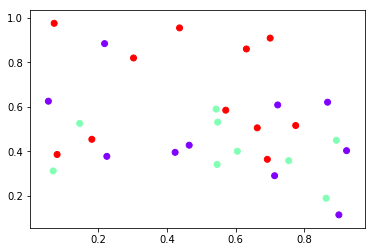

In [30]:
plt.figure()
plt.scatter(X[:,0],X[:,1], c=y, cmap='rainbow')

Create an instance of `sklearn`'s KNN, with $k=1$.

In [31]:
k = 3
classifier = neighbors.KNeighborsClassifier(k)

Fit the classifier to your data. Use uniform weights.

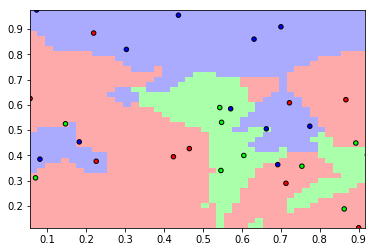

In [32]:
classifier.fit(X, y)

h=0.02
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

Visualize the classification regions of $[0,1]\times [0,1]$. You might find [this](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py) code example useful.

Repeat this step for different values of $k$, and make sure you understand how the classification regions change.

## Step 2: Choosing an Optimal Value for k Using Cross Validation

In this part of the exercise, we'll use cross validation to choose the best value for our hyperparameter, $k$.

First, we'll have to make our label-generation a bit more sophisticated than just plain random numbers (why?).

We begin by sampling our points in $[-1,1]\times [-1,1]$. Now, we will attempt to sample the labels such that points in the first and third quadrant will have a higher probability of samplying a 1-label ($\Pr [label = 1] = \frac{3}{4}$), and points in the second and fourth quadrant will have a higher probability of sampling a 0-label ($\Pr [label = 0] = \frac{3}{4}$). 

This can be done quite easily by defining the following the label of each sample `X[i,:]=[x_1, x_2]` as a Bernoulli random variable with probability of success $$ p = \frac{1}{2} + (-1)^{\mathrm{sign} (x_1) \cdot \mathrm{sign} (x_2)} \cdot \frac{1}{4}. $$

In [44]:
def generate_points_with_labels2(n=100):
    X, _ = generate_points_with_labels(n=n, max_label=1) # only two kinds of labels, 0 or 1
    X = X*2-1 # transforms the points in X to [-1,1]X[-1,1] 
    
    ps = np.zeros(n)
    for i in range(n):
        ps[i] = 0.5 + (((-1) ** (np.sign(X[i, :])[0] * np.sign(X[i, :])[1] )) * 0.25 )
    y = np.random.binomial(1, ps, n)
    return X, y

Plot the points, and color each label according to its label.

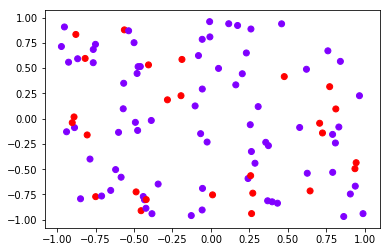

In [45]:
X, y = generate_points_with_labels2()
plt.figure()
plt.scatter(X[:,0],X[:,1], c=y, cmap='rainbow')

Split the set of points into two sets, `train` and `test`, such that `train` contains $80\%$ of the data and `test` contains the other $20\%$.

In [58]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

(80, 2)
(80,)
(20, 2)
(20,)


Split the train test into 4-folds (equal-size parts, i.e. $20\%$ of the original data each).

In [59]:
folds_Xs, folds_ys = np.split(train_X, 4), np.split(train_y, 4)

Find the best value for $k$ using 4-fold cross validation, that is:

1. For every value of $k$ from 1 to 10,
 1. For every $i$ from 0 to 3,
     1. Create KNN classifier with current $k$.
     1. Fit the classifier on $ \text{train} \setminus \text{fold}_i $.
     1. Evaluate the accuracy of classifier on $\text{fold}_i$.
        
Save all evaluations (throughout all iterations) in a dictionary of lists ` { k => [list of four accuracies] }`.

In [79]:
accuracies = {}
for k in range(1,11):
    accuracies[k] = list()
    for i in range(4):
        classifier = neighbors.KNeighborsClassifier(k)
        classifier.fit(folds_Xs[i], folds_ys[i])
        predictions = classifier.predict(test_X)
        similar_indices = np.where(predictions == test_y)
        accuracies[k].insert(i, len(similar_indices[0])/predictions.shape[0])

For every $k$, compute its mean accuracy (taken on all folds). Save the results a $ (\text{num_values_of_k}) \times 2 $ array, where the $i$th row contains is `[k_i, mean_accuracy_i]`.

In [81]:
results = np.zeros([11, 2])
for i in range (1,11):
    results[i, :] = np.array([i, np.mean(accuracies[i])])
print(results)

[[ 0.      0.    ]
 [ 1.      0.5375]
 [ 2.      0.6   ]
 [ 3.      0.525 ]
 [ 4.      0.5875]
 [ 5.      0.5625]
 [ 6.      0.6   ]
 [ 7.      0.6   ]
 [ 8.      0.6   ]
 [ 9.      0.6   ]
 [10.      0.6   ]]


Plot a graph of mean accuracies.

In [10]:
# TODO

Conclude the optimal value of $k$ given your train set.

In [11]:
k_opt = 2

Create a KNN classifier with $k_{opt}$, and evaluate its accuracy on the test set.

In [ ]:
# TODO